# Predicting the daily returns and directions of returns of SPY using technical indicators and fundamental indicators.
### By Seine Yumnam - 2017

In this project, I will be working on predicting the daily returns / direction of returns of SPY to ultimately build a trading strategy. Daily returns are the percentage changes on a day to day basis. Direction is simply the sign of the percentage change, indicating an up or a down day. SPY is an Exchange Traded Fund that tracks S&P500. It is a stock of stocks. 
We will be using multiple technical and fundamental indicators. The technical indicators are calculated in this notebook; however, the fundamental indicators are based on a paper titled "A Practitioner's Defense of Return Predictability" by Blair Hull and Xiao Qiao. The paper can be found at SSRN - https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2609814

Fortunately, Hull Investments also provides the data they used in the paper. The excel file can be found here - http://www.hullinvest.com/HI/our-approach/

### What are technical indicators?
Technical indicators are mathematical manipulation of the price and volume series of a stock. 

### What are fundamental indicators?
Fundamental indicators are the features of a company such as their revenue, earnings, cost of raw materials, profits, etc. 


### Trading Strategy

Before we start cleaning data, creating new variables and running the machine learning algorithm, let's quickly go through the trading strategy
we are planning to build. 
The process is as follows - 
1. Design models for predicting the daily returns of SPY or the direction of the returns. 
2. At time t, if the model predicts that the return for t+1 will be positive, then we go long SPY at market close. 
3. At time t, if the model predicts that the return for t+1 will be negative, then we go short SPY at market close. 
4. Predict every day and adjust the position every day. 

### What does this mean?
We will have two types of models - one that predicts the percentage change in price and the other that predicts whether SPY will be up or down. If the model predicts that tomorrow's price will be higher than today's, we will buy SPY and make money if the price actually goes up. If the models predicts that the price will be lower, we sell SPY and if the price actually goes down, we will make money. We will then add up the profit or loss we make every day and find the cumulative i.e. the total amount of money we have made over the course of time. For this project, we will assume that we start with $1. If at the end of the trading period we have more than 1 dollar, then our strategy has made money. If the ending amount is less than 1 dollar, then we have lost money from trading. 


In [2]:
#Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler #we won't be using this
from sklearn.decomposition import PCA #we won't be using this
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_style("white")
np.random.seed(7)
from astropy.table import Table, Column

%matplotlib inline

/projects/sage/sage/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data and variables

As mentioned before, all the fundamental information are taken from Hull Investments. The data they provide is only upto 5/4/2015, so my dataset does not go beyond this date. 
The price series and the volume series are taken from CBOE website and ycharts. 

#### Technical indicators: 
Some of these might be called quantitative indicators as well, especially the 14th and 15th 
indicators.  
1. SPY_prior_ret – 1-day lagged return of SPY. If we are predicting the return of time t, this will be the return of t-1. Daily returns are calculated from close to close. 
2. VIX_prior_ret – 1-day lagged return of CBOE VIX. VIX is calculated using the implied volatility of 30 days out SPX options. 
3. MSCI_EM_prior_ret – 1-day lagged return for the emerging market.
4. SPY_trend – this is used to define whether SPY is in an uptrend or a downtrend. The calculation of this will be shown in python code later in the book. 
5. RSI – Relative strength index.
6. MACD_signal – crossover of MACD and the 9-ema MACD. MACD is Moving average convergence divergence.
7. ROC – Rate of change. 8. S0d – Stochastic oscillator. 
9. IBS – Internal Bar Strength Indicator. This was based on an article published by Jonathan Kinlay. Calculation will be shown in python codes. 
10. excess_volume_prior – this is daily volume minus the 30-day average volume expressed as a percentage of the 30-day average volume.   
11. SPY_Z_score – this is the expanding z-score of SPY returns. While calculating this, we should ensure that we are not using the entire data to calculate the mean and the standard deviation. If we do, our work will suffer from data snooping. Thus, I calculated the z-score based on the data I have at a given point in time.   
  
Data from Hull and Qiao: 
12. Moving Average (MA_prior): buy and sell rules based on the relative levels of the current price versus the past 10-month simple moving average (Faber 2007). 
13. Oil Price Shocks (OIL_prior): OIL is constructed as the log of the current front oil futures (Casassus and Higuera 2011).  
14. Implied Correlation (IC_prior) is the average equity options-implied correlation (Driessen, Maenhout, and Vilkov 2013). 
15. Variance Risk Premium (VRP_prior) is VIX squared minus the five-minute realized variance (Bollerslev, Tauchen, and Zhou 2009). Hull and Qiao used VIX minus the volatility forecast from a GARCH model following Yang and Zhang’s style (2000). 
16. SIM_prior - Sell in May and Go Away (Bouman and Jacobsen 2002 and Doeswijk 2009). 
17. PCR - Ratio of Stock Price to Commodity Price (Black et al (2014). 18. PCA.tech – principal component analysis of technical indicators (Neely et al 2014). 

#### Fundamental data from Hull and Qiao: 
19. DP_prior is Dividend-Price Ratio (Fama and French 1988).
20. PE_prior is Price-to-Earnings Ratio (Campbell and Shiller 1988). 
21. BM_prior is Book-to-Market Ratio (Pontiff and Schall 1998). 
22. CAPE_prior is Cyclically Adjusted Price to Earnings Ratio (Shiller 2000).
23. PCA_prior - price is Principal Component of Price Ratios that includes DP, PE, BM, and CAPE.
24. BY_prior is Bond Yield (Pastor and Stambaugh 2009). 
25. DEF_prior is Default Spread, which is the difference between the Baa and Aaa corporate bond yields (Fama and French 1989). 
26. Term Spread (TERM_prior) is the yield difference between the 10-year Treasury Note and the three-month Treasury Bill (Fama and French 1989). 
27. Cointegrating Residual of Consumption, Assets, and Wealth (CAY_prior) is cointegrating residual of log consumption, assets, and wealth (Lettau and Ludvigson 2001). 
28. BDI_prior is Baltic Dry Index (Bakshi, Panayotov, and Skoulakis 2011). 
29. NOS_prior is New Orders/Shipments (Jones and Tuzel 2012). 
30. CPI_prior is Consumer Price Index (Campbell and Vuolteenaho 2004). 
31. Short Interest (SI_prior): the average of short interest divided by total shares outstanding of individual stocks (Rapach, Ringgenberg, and Zhou 2015). In Hull and Qiao’s paper, they calculated this as the sum of all shares short on the NYSE divided by the average daily trading volume over the past 30 days. 

### Target variable
We will be looking to solve two different problems. The first one is to predict the daily returns and the other one is to predict the direction of market movements. 
So, we will be working with both classification and regression models. 
Daily returns are the percentage change in price on a day to day basis. Direction is simply the sign of the percentage change. So, it will be -1 for negative percentage change and 1 for positive percentage change. 

In [3]:
data = pd.read_csv('data.csv', na_values = ".")
data.rename(columns={'Close': 'SPY'}, inplace=True) #renaming the variable close as SPY
data.head(2)

Period   Open   High    Low    SPY  Volume    VIX   MSCI_EM        DP  \
0  6/1/1994  45.70  46.02  45.56  46.02  200500  12.72  491.7804  0.034584   
1  6/2/1994  46.05  46.05  45.89  45.97   55100  12.73  488.5272  0.034619   

        PE    ...     VRP        IC       BDI       NOS       CPI       PCR  \
0  20.2080    ...     0.0  0.222283  0.020154  0.002355  0.023644 -1.717803   
1  20.2407    ...     0.0  0.248541  0.007653  0.002355  0.023644 -1.722802   

   MA  PCA.tech       OIL        SI  
0   1 -2.292294  0.210050 -0.189024  
1   1 -2.283709  0.211826 -0.187592  

[2 rows x 28 columns]

In [4]:
np.array(list(data))  #the csv file we loaded has 28 data series, excluding the index column. The rest of the technical indicators will be calculated along the way. 

array(['Period', 'Open', 'High', 'Low', 'SPY', 'Volume', 'VIX', 'MSCI_EM',
       'DP', 'PE', 'BM', 'CAPE', 'PCA.price', 'BY', 'DEF', 'TERM', 'CAY',
       'SIM', 'VRP', 'IC', 'BDI', 'NOS', 'CPI', 'PCR', 'MA', 'PCA.tech',
       'OIL', 'SI'], 
      dtype='|S9')

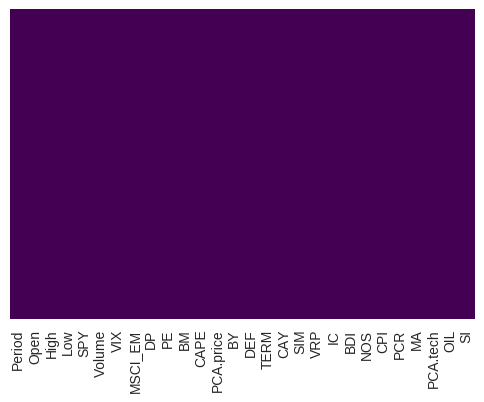

In [5]:
#Now that we have read the data, let's see if we have any missing values in any of the columns.
#We will use seaborn's heatmap to do so. 
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
#As we can see, there are not missing data. If we had any, there will be yellow marks for the missing rows. 

In [6]:
#Let's make sure that the data types are correct. The period should be a datetime datatype while the rest should be numeric. 
data.ix[:, 1:28] = data.ix[:, 1:28].apply(pd.to_numeric)
data["Period"] = pd.to_datetime(data["Period"])

In [7]:
#Look at the sample size and the first and the last date of the time series. 
print('Sample Size: {}'.format(len(data)))
print(data['Period'].min())
print(data['Period'].max())

Sample Size: 5269
1994-06-01 00:00:00
2015-05-04 00:00:00


Let’s now work on lagging the features. As mentioned before, we are trying to predict the return/direction of SPY at time t using the data we have at time t-1. So, we need to organize the python dataframe in such a way that the return of time t is matched with the features of time t-1 row-wise. 

In [8]:
data.reset_index(inplace=True)
data_lagged=data.copy()
data_lagged['index'] = data_lagged['index'].apply(lambda x: x+1)
data_merged = data.merge(data_lagged, how="left", on="index", suffixes=("","_prior"))

index     Period   Open   High    Low    SPY  Volume    VIX   MSCI_EM  \
0      1 1994-06-01  45.70  46.02  45.56  46.02  200500  12.72  491.7804   
1      2 1994-06-02  46.05  46.05  45.89  45.97   55100  12.73  488.5272   

         DP    ...     VRP        IC       BDI       NOS       CPI       PCR  \
0  0.034584    ...     0.0  0.222283  0.020154  0.002355  0.023644 -1.717803   
1  0.034619    ...     0.0  0.248541  0.007653  0.002355  0.023644 -1.722802   

   MA  PCA.tech       OIL        SI  
0   1 -2.292294  0.210050 -0.189024  
1   1 -2.283709  0.211826 -0.187592  

[2 rows x 29 columns]

In [10]:
#Let's now drop columns we won't be needing anymore.
data_merged.drop(['Period_prior', 'Open', 'High', 'Low','Volume', 'VIX', 'MSCI_EM','DP', 'PE', 'BM', 'CAPE',
                  'PCA.price', 'BY', 'DEF', 'TERM', 'CAY','SIM', 'VRP', 'IC', 'BDI', 'NOS', 'CPI', 'PCR',
                  'MA', 'PCA.tech','OIL', 'SI'], axis = 1, inplace = True)
data_merged.dropna(inplace = True)
#This might be a little confusing. The idea is that we should be using whatever we have at a given point 
#in time to predict tomorrow's price. 
#Here, we will be using prior (data at time t) data to predict the return at time t+1. 

### Let's start making calculations and creating technical indicators, which are just mathematical manipulations of the price series and the volume data. 

Let's start calculating technical indicators for the SPY time series. We will be creating 8 different technical indicators based on the OHLC(open, high, low, close(SPY)) and volume data series. The 8 technical indicators are as follows. Brief description of each indicator will be added as we create them. 

Technical Indicators for the price series - 
Trend, Relative Strength Index(RSI), Moving Average Convergence Divergence(MACD), Z-score of returns, Rate of Change(ROC), Stochastic Oscillator(S0K / S0d. 

Technical Indicators for the volume series - 
Excess-volume, On Balance Volume.

For more details on each indicator, please go to stockcharts.com

In [11]:
#Daily return
rets = data_merged[['SPY', 'SPY_prior', 'VIX_prior','MSCI_EM_prior']]
for i in rets:
    data_merged[i + '_ret'] = np.log(data_merged[i] / data_merged[i].shift(1))

#Trend Indicator
data_merged['SPY_50'] = pd.rolling_mean(data_merged['SPY_prior'], window=50)#this is the 50-day moving average
data_merged['SPY_trend'] = (data_merged['SPY_prior'] - data_merged['SPY_50'])/ data_merged['SPY_50'] 

#Relative Strength Index (RSI)
def relative_strength(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 1. - 1./(1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  
        
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n - 1) + upval)/n
        down = (down*(n - 1) + downval)/n

        rs = up/down
        rsi[i] = 1. - 1./(1. + rs)

        data_merged['RSI'] = rsi

relative_strength(data_merged['SPY_prior'], n=14)

#MACD indicator
def moving_average(x, n=9):
    sma = pd.rolling_mean(x, n)
    return sma

def moving_average_convergence(x, nslow=26, nfast=12):
    emaslow = pd.ewma(x, span=nslow, min_periods=1)
    emafast = pd.ewma(x, span=nfast, min_periods=1)
    result = pd.DataFrame({'MACD': emafast-emaslow, 'emaSlw': emaslow, 'emaFst': emafast})
    return result

data_merged[['MACD', 'emaSlw', 'emaFst']] = moving_average_convergence(data_merged['SPY_prior'], 26, 12)
data_merged['ema_9_MACD'] = pd.ewma(data_merged['MACD'], span=9, min_periods=1)
#when the MACD crosses above the 9 ema of the MACD, it is considered bullish and the opposite is bearish. let's take the difference between MACD and ema_9_MACD to show this
data_merged['MACD_signal'] = data_merged['MACD'] - data_merged['ema_9_MACD']

#ROC indicator
def ROC(data_merged, n):  
    M = data_merged['SPY_prior'] - data_merged['SPY_prior'].shift(n)
    N = data_merged['SPY_prior'].shift(n)  
    ROC = pd.Series(M / N) 
    data_merged["ROC"] = ROC 
    
#Calculating ROC    
ROC(data_merged, 14)

#Stochastic oscillator.
#Stochastic Oscillator is a momentum indicator that shows the location of the close(price at the end of the day) relative to the high-low range over a set number of periods.
 
#creating the function.
def STO(data_merged, n):  
    SOk = (data_merged['SPY_prior'] - data_merged['Low_prior'].rolling(window=n).min()) / (data_merged[
                'High_prior'].rolling(window=n).max() - data_merged['Low_prior'].rolling(window=n).min()) 
    
    SOd = pd.ewma(SOk, span = 3) 
    data_merged['S0d'] = SOd  
    
#Calculating STO
STO(data_merged, 14)


#Internal Bar Strength Indicator. 
#It takes a value of 0 if the closing (price at the end of the day) price is the lowest price of the day, and 1 if the closing price is the highest price of the day.
#I found this blog and it does a pretty good job in predicting the market - http://jonathankinlay.com/2016/06/the-internal-bar-strength-indicator/
#IBS  =  (Close – Low) / (High – Low)
#there is actually a short paper on this - http://qusma.com/wp-content/uploads/2013/09/The-IBS-Effect-Mean-Reversion-in-Equity-ETFs.pdf

data_merged['IBS'] = (data_merged['SPY_prior'] - 
                      data_merged['Low_prior']) / (data_merged['High_prior'] - data_merged['Low_prior'])

#Let's work with the volume data
#Excess volume is the difference between the daily volume and the 30-day moving average volume expressed as a percentage of the 30-day moving average. 
#If this number is positive, the daily volume for the given day is higher than the 30-day moving average. Otherwise, it is below. 
data_merged['excess_volume_prior'] = (data_merged['Volume_prior'] - pd.rolling_mean(data_merged['Volume_prior'], window = 30))/ (pd.rolling_mean(data_merged[
            'Volume_prior'], window = 30))

#We have one more price based indicator to calculate. That is, Z-score. 
#In order to prevent data snooping, we need to make sure we do expanding z-score. 
#This means that we use the data we have at a given point in time to calculate the mean and the standard deviation.

data_merged['SPY_Z_score'] = (data_merged['SPY_prior_ret'] - data_merged[
        'SPY_prior_ret'].expanding(min_periods=1).mean())/data_merged['SPY_prior_ret'].expanding(min_periods=1).std()

/projects/sage/sage-7.5/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
/projects/sage/sage-7.5/local/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=26,min_periods=1,adjust=True).mean()
/projects/sage/sage-7.5/local/lib/python2.7/site-packages/ipykernel/__main__.py:47: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=12,min_periods=1,adjust=True).mean()
/projects/sage/sage-7.5/local/lib/python2.7/site-packages/ipykernel/__main__.py:52: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=9,min_periods

In [12]:
#let's make another column that shows the direction of the daily market movement. 
#If the percentange change is negative (this means that the price is lower), we will have -1, if it is positive, we will have 1. 0 return will be given -1. 
#This will help in building classification models. 

#define target direction
data_merged['SPY_direction'] = np.where(data_merged['SPY_ret'] > 0, 1, -1)
data_merged['SPY_direction'] = data_merged['SPY_direction'].astype('category')

In [13]:
#Let's get rid of rows that have NAs in it. 
data_merged.dropna(inplace=True)

#let's apply a non-visual way of checking for NAs
print(np.any(np.isnan(data_merged.ix[:, 2:32])))
#I get FALSE for this code and it shows that we don’t have any NA value in any of the rows

#let's check if we have any infinite values. 
print(np.all(np.isfinite(data_merged.ix[:,2:32])))
#I get TRUE for this code indicating that all the values are finite

#Along the way, we have dropped some rows. So, our dataframe indexing isn’t starting from 0. Let’s fix this. This will become handy when we are doing time series split.
data_merged.drop('index', axis = 1, inplace = True)
data_merged.reset_index(inplace=True)
data_merged.drop('index', axis=1,inplace=True)

False
True


### Let's start building models


#### TimeSeriesSplit - Train/test splitting the time series data. K-fold split does not work in time series prediction

In [14]:
#let's see how many observations we have. 
len(data_merged)

5217

Train/test splitting. 
In time series, the order of the data is of utmost importance. So, we can't use k-fold split.
Instead, we need to do time series split where the temporal order is preserved. 
We have 5217 rows in the dataset. We will be using the first 4000 rows as the train set and the rest as the testing set.

In [15]:
#Let's create training and testing subsets
cutoff = 4000

train_set = pd.DataFrame()
test_set = pd.DataFrame()
train_set = data_merged[data_merged.index < cutoff].copy()
test_set = data_merged[data_merged.index >= cutoff].copy()

Observations: 5217
Training Observations: 4000
Testing Observations: 1217


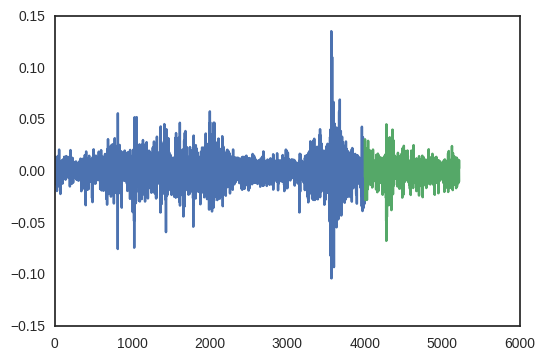

In [16]:
print('Observations: %d' % (len(data_merged)))
print('Training Observations: %d' % (len(train_set)))
print('Testing Observations: %d' % (len(test_set)))
plt.plot(train_set['SPY_ret'])
plt.plot([None for i in train_set['SPY_ret']] + [x for x in test_set['SPY_ret']])
plt.show()
#the blue ones are in the training set and the green ones in the testing set. 

### How do we compare models?

Most of the research papers I have read end their papers by simply looking at the models from a modeling perspective and not trading 
perspective. If the paper is studying regression models, it would end by comparing the Root Mean 
Square Error (RMSE) of the models and rank the models based on this. For classification models, 
it would end with confusion matrix or accuracy-precision matrix and rank them accordingly. I find 
this method non-economical and I believe that Hull and Qiao would agree with me. I will look at 
RMSE and confusion matrix for regression and classification models respectively to optimize models; however, I won’t 
give as much emphasis on them as other research papers have done. Instead, I will look at the equity 
curve of the trading strategy each model can build and look at the Annualized Return, Annualized Volatility, and Sharpe Ratio to compare the models. 

The annualized return is the geometric average amount of money earned by an investment each year over a given time period. It is calculated as a geometric average to show what an investor would earn over a period of time if the annual return was compounded. Volatility is the standard deviation of the returns. It measures how stable our money making trading strategy is. If we lose a lot and also make a lot, then the volatility is high. We don't want that. we want stability in our daily profits. Sharpe ratio is the risk adjusted return and it is calculated by dividing the annualized return by the volatility. The higher it is, the better the trading strategy is.

So, we want high annualized return with lower volatility so that we get high sharpe ratio.

### For regression models

In [17]:
#Let's seperate the features and the target. 
# training features
train_features = train_set[['SPY_prior_ret','VIX_prior_ret','SPY_trend','RSI','MACD_signal', 'ROC','S0d',
                            'SPY_Z_score','excess_volume_prior','IBS','MSCI_EM_prior_ret','DP_prior', 'PE_prior', 'BM_prior',
                            'CAPE_prior','BY_prior', 'DEF_prior','TERM_prior', 'CAY_prior', 'SIM_prior', 
                            'VRP_prior', 'IC_prior', 'BDI_prior','NOS_prior', 'CPI_prior', 'PCR_prior', 'MA_prior',
                            'OIL_prior', 'SI_prior']]

# training target 
train_target = train_set['SPY_ret']

#testing features
test_features = test_set[['SPY_prior_ret','VIX_prior_ret','SPY_trend','RSI','MACD_signal', 'ROC','S0d','SPY_Z_score',
                          'excess_volume_prior','IBS','MSCI_EM_prior_ret','DP_prior', 'PE_prior', 
                          'BM_prior', 'CAPE_prior','BY_prior', 'DEF_prior','TERM_prior', 'CAY_prior', 'SIM_prior',
                          'VRP_prior', 'IC_prior', 'BDI_prior','NOS_prior', 'CPI_prior', 'PCR_prior', 'MA_prior', 
                          'OIL_prior', 'SI_prior']]
#'PCA.tech_prior'

#testing target 
test_target = test_set['SPY_ret']

#pick out the dates for the test set
dates = test_set['Period']

If you carefully look at the features I have chosen, you will see that it does not have two of the 
features I described before. It does not have 'PCA.price_prior' and 'PCA.tech_prior'. We know that 
'PCA.price_prior' is the principal component of four of the price related fundamental features i.e. 
DP, PE, BM, and CAPE. So, while running our models, we can either use the principal component 
of these features or the features themselves. I found that using the features produces a better 
trading strategy and that is the reason I am not using the principal component.  'PCA.tech_prior' 
is the principal component of technical indicators. Since I already have many technical indicators, 
I took this off as well. However, you will later that adding these features make Random Forest a 
better model

### We will start with Linear Regression model. 

Let's now run a linear regression model as a starter. Going in we should know that linear regression is typical used for inference and does a poor job at prediction. 
So, we should not be surpised if we see poor performance. 

In [22]:
def fitAndPlot(train_features, test_features, model, **extraArgs):

    # Create linear regression object
    SPY_ret_model = model(**extraArgs)

    # Fit the data
    SPY_ret_model.fit(train_features,train_target)

    # Get the predictions
    predictions = SPY_ret_model.predict(test_features)
    
    #let's design the strategy
    directions = pd.DataFrame()
    directions = np.sign(predictions)
    strategy = directions * test_target
    
    strategy_equity_curve = strategy.cumsum().apply(np.exp)
    buy_and_hold_equity_curve = test_target.cumsum().apply(np.exp)

    # Plot the actuals and the predictions
    f, (ax1) = plt.subplots(1, 1, figsize=(7,5))

    ax1.plot(dates,strategy_equity_curve,linestyle='--', label = 'Strategy')
    ax1.plot(dates,buy_and_hold_equity_curve, label = 'SPY_buy&hold')
    ax1.legend(loc=0)
    ax1.set_ylabel('Performance')
    ax1.set_xlabel('Dates')
    f.autofmt_xdate()
    #plt.tight_layout()    
 

    print("Model RMS Error: {0:.10f} for {1}".format(np.sqrt(np.mean((predictions - test_target) ** 2)),model.__name__))
    print('Annualized return') 
    print((strategy.mean()*252)*100)
    print('Volatility') 
    print((strategy.std()*252**0.5)*100)
    print('Sharpe Ratio')
    print((strategy.mean()*252) / (strategy.std()*252**0.5))
    
    return (SPY_ret_model)

Model RMS Error: 0.0095786006 for LinearRegression
Annualized return
16.7042739114
Volatility
15.1454416688
Sharpe Ratio
1.10292418515


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

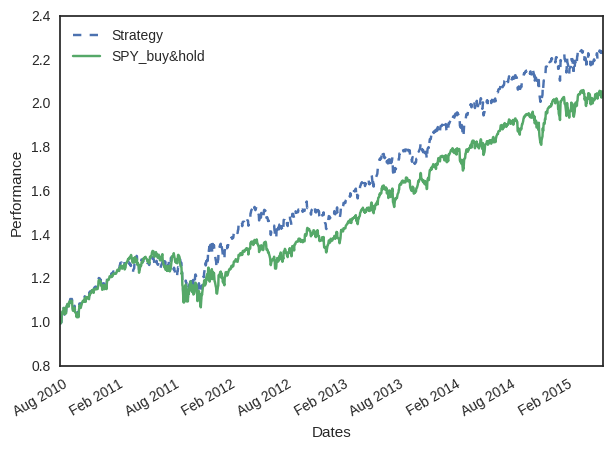

In [23]:
fitAndPlot(train_features, test_features, LinearRegression)

Let's take some time to discuss what the graphs mean. The first graph is the scatter diagram of the actual return vs the predicted return. If the predicted value was the same as the actual value, all the numbers will lie on the 45 degree line. The higher the mismatch, the further away the points will be from the 45 degree line. The second graph is called the equity curve. It is the cummulative sum of all the money we have made since we started trading using the model we have created. We started with 1 dollar and ended with about $2.2 for this strategy.  

In [29]:
# Linear Regression do well when the features are uncorrelated or have low correlation. So, let's try to filter the features by 
# looking at the correlation. 

correl = data_merged[['SPY_prior_ret','VIX_prior_ret','SPY_trend','RSI','MACD_signal', 'ROC','S0d','SPY_Z_score','excess_volume_prior','IBS',
                           'MSCI_EM_prior_ret','DP_prior', 'PE_prior', 'BM_prior', 'CAPE_prior', 'PCA.price_prior', 'BY_prior', 'DEF_prior',
                            'TERM_prior', 'CAY_prior', 'SIM_prior', 'VRP_prior', 'IC_prior', 'BDI_prior','NOS_prior', 
                            'CPI_prior', 'PCR_prior', 'MA_prior','OIL_prior', 'SI_prior']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correl, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correl, annot=True, mask=mask, cmap=cmap, vmax=.3,
            square=True,linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Let's first select 'SPY_prior_ret' and choose the features that have low correlation to it. 
We will then run the new linear regression and evaluate the result. 

In [25]:
#SPY_prior_ret has higher correlation with the technical indicators than with the fundamental indicators. 
#Let's see how the linear model does when we use only the prior return and the fundamental data. 
#training features
new_train_features = train_set[['SPY_prior_ret','DP_prior', 'PE_prior', 'BM_prior', 'CAPE_prior', 
                                'BY_prior', 'DEF_prior','TERM_prior', 'CAY_prior', 
                                'BDI_prior','NOS_prior','CPI_prior','SI_prior']]

#testing features
new_test_features = test_set[['SPY_prior_ret','DP_prior', 'PE_prior', 'BM_prior', 'CAPE_prior',
                              'BY_prior', 'DEF_prior','TERM_prior', 'CAY_prior',
                              'BDI_prior','NOS_prior','CPI_prior','SI_prior']]

Model RMS Error: 0.0096129752 for LinearRegression
Annualized return
15.0352261001
Volatility
15.1523857347
Sharpe Ratio
0.99226790839


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

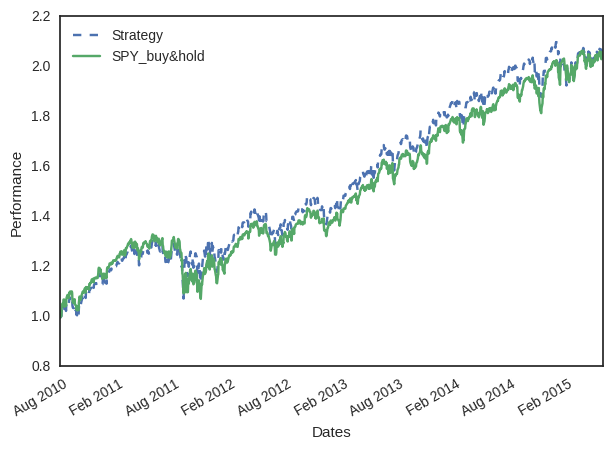

In [26]:
 fitAndPlot(new_train_features,new_test_features,LinearRegression)

### Correlation screen didn't improve the model. However, the screening was manually done through observation. 
What do I mean by 'didn't improve'? 
As I mentioned before, I am looking at the Annualized return, volatility, sharpe ratio and the equity curve. This model has lower Annualized return with same volatility and hence lower sharpe ratio compared to the previous linear model. We can also see that the 1 dollar that we invested in the beginning is worth less than the amount the first linear model gave us. 

Let's now apply univariate feature selection and see if we can improve the linear model. 

In [41]:
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

select_feature = feature_selection.SelectKBest(score_func=feature_selection.f_regression,k=10)
results = select_feature.fit(train_features, train_target)
print(results.scores_)
print(results.pvalues_)

[ 17.69540362   7.24068203   5.65367092   4.85199601   9.50068665
   4.96110733   5.31465444  15.78372671   3.30077913  13.3055693
  11.04820317   3.38746021   1.16954727   0.72293299   0.49430467
   0.63567057   1.49050356   0.62614408   3.49932142   0.08189534
   1.60210177   1.51093826   2.54957133   0.86600884   4.75583815
   0.01823435   1.03783334   0.46225978   3.65703802]
[  2.64936412e-05   7.15663838e-03   1.74656205e-02   2.76710215e-02
   2.06794280e-03   2.59790630e-02   2.11977465e-02   7.22618509e-05
   6.93218739e-02   2.67992673e-04   8.95724650e-04   6.57681361e-02
   2.79559510e-01   3.95234432e-01   4.82054283e-01   4.25330256e-01
   2.22210341e-01   4.28820167e-01   6.14669816e-02   7.74759980e-01
   2.05679368e-01   2.19068311e-01   1.10403216e-01   3.52118792e-01
   2.92571657e-02   8.92591290e-01   3.08387559e-01   4.96609117e-01
   5.59041963e-02]


### Let's now pick 5 features based on the ranking and statistical significance. 
The top 5 features are 'SPY_prior_ret', 'SPY_Z_score', 'MSCI_EM_prior_ret', 'IBS', 'MACD_signal'

In [30]:
#training features
newer_train_features = train_set[['SPY_prior_ret', 'SPY_Z_score', 'MSCI_EM_prior_ret', 'IBS', 'MACD_signal']]

#testing features
newer_test_features = test_set[['SPY_prior_ret', 'SPY_Z_score', 'MSCI_EM_prior_ret', 'IBS', 'MACD_signal']]

Model RMS Error: 0.0095429543 for LinearRegression
Annualized return
6.57156824167
Volatility
15.1763327196
Sharpe Ratio
0.433014244157


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

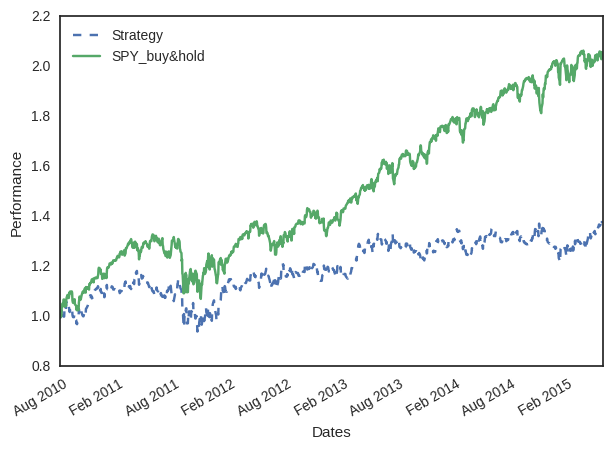

In [31]:
fitAndPlot(newer_train_features, newer_test_features, LinearRegression)

The result of this model is blatantly bad. So, we will use the first linear model as a benchmark and develop other advanced models and see if we can beat the best linear model we have so far. 

### Benchmark Linear Model Performance:
#### Annualized return - 16.16%
#### Volatility - 15.15%
#### Sharpe Ratio - 1.07

In [32]:
all_train_features = train_set[['SPY_prior_ret','VIX_prior_ret','SPY_trend','RSI','MACD_signal', 'ROC','S0d',
                            'SPY_Z_score','excess_volume_prior','IBS','MSCI_EM_prior_ret','DP_prior', 'PE_prior', 'BM_prior',
                            'CAPE_prior','BY_prior', 'DEF_prior','TERM_prior', 'CAY_prior', 'SIM_prior', 
                            'VRP_prior', 'IC_prior', 'BDI_prior','NOS_prior', 'CPI_prior', 'PCR_prior', 'MA_prior',
                            'OIL_prior', 'SI_prior','PCA.tech_prior','PCA.price_prior']]

#testing features
all_test_features = test_set[['SPY_prior_ret','VIX_prior_ret','SPY_trend','RSI','MACD_signal', 'ROC','S0d','SPY_Z_score',
                          'excess_volume_prior','IBS','MSCI_EM_prior_ret','DP_prior', 'PE_prior', 
                          'BM_prior', 'CAPE_prior','BY_prior', 'DEF_prior','TERM_prior', 'CAY_prior', 'SIM_prior',
                          'VRP_prior', 'IC_prior', 'BDI_prior','NOS_prior', 'CPI_prior', 'PCR_prior', 'MA_prior', 
                          'OIL_prior', 'SI_prior','PCA.tech_prior','PCA.price_prior']]

You might have noticed that two of the features I did not use in the best linear model 
are included in this one, namely ‘PCA.tech_prior’ and ‘PCA.price_prior.’ The reason is simple. 
Adding them improves the trading strategy that comes out of the Random Forest Regression model.

In [39]:
#After running Random Forest Regression, AdaBoost Regression, and Gradient Boosting Regression models, the only model that beats the Benchmark Linear Model is the Random Forest model. 
a = np.array(['Random Forest Regression','AdaBoost Regression', 'Gradient Boosting'], dtype=np.str_)
b = ['17.52%','0.39%','5.75%']
c = ['15.14%','15.18%','15.17%']
d = ['1.16','0.025','0.38']
t = Table([a, b, c,d], names=('Model type ', 'Annualized Return', 'Annualized Volatility ', 'Sharpe Ratio '))
t


<Table length=3>
      Model type         Annualized Return Annualized Volatility  Sharpe Ratio 
         str24                  str6                str6               str5    
------------------------ ----------------- ---------------------- -------------
Random Forest Regression            17.52%                 15.14%          1.16
     AdaBoost Regression             0.39%                 15.18%         0.025
       Gradient Boosting             5.75%                 15.17%          0.38

So far, Random Forest is the only models that have beaten the Benchmarch Linear Model. With the same volatility, the Random Forest model produces an annualized return that is about 3.60 percent higher. It also has a higher sharpe ratio compared to the Benchmarch Linear Model. 

## Model Optimization 

### Random Forest Regression Hyperparameter Tuning
We will tune the Random Forest model hyperparameters, focusing on the minimum number of samples per leaf for the underlying decision tree regressor. 

In [86]:
#Let's first try to optimize random forest regression. 
min_leaf_grid = range(1,80,4)
rms_scores = []
for  min_leaf in min_leaf_grid:
    
    print("Working min_leaf {}".format(min_leaf))
    SPY_ret_model = RandomForestRegressor(min_samples_leaf=min_leaf, n_estimators=300,random_state=32)

    # Fit the data
    SPY_ret_model.fit(all_train_features,train_target)

    # Get the predictions
    predictions = SPY_ret_model.predict(all_test_features)
    
    rms_score = np.sqrt(np.mean((predictions - test_target) ** 2))
    rms_scores.append(rms_score)

plt.plot(min_leaf_grid, rms_scores,marker='o')
plt.xlabel("Minimum Number of Leaves")
plt.ylabel("RMS Error")

Working min_leaf 1
Working min_leaf 5
Working min_leaf 9
Working min_leaf 13
Working min_leaf 17
Working min_leaf 21
Working min_leaf 25
Working min_leaf 29
Working min_leaf 33
Working min_leaf 37
Working min_leaf 41
Working min_leaf 45
Working min_leaf 49
Working min_leaf 53
Working min_leaf 57
Working min_leaf 61
Working min_leaf 65
Working min_leaf 69
Working min_leaf 73
Working min_leaf 77


As we can see, the RMSE decreases exponential in the beginning but eventually it sort of flattens out.
Let's now increase the minimum leaves and see if we can improve the random forest model. 
Let’s try using 30 min_sample_leaf instead of 10.  I have also increased the n_estimators to reduce noise in the trend data. 

### Optimized Random Forest 

Model RMS Error: 0.0096302376 for RandomForestRegressor
Annualized return
18.7305741385
Volatility
15.1360246394
Sharpe Ratio
1.2374830634


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=30,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=32,
           verbose=0, warm_start=False)

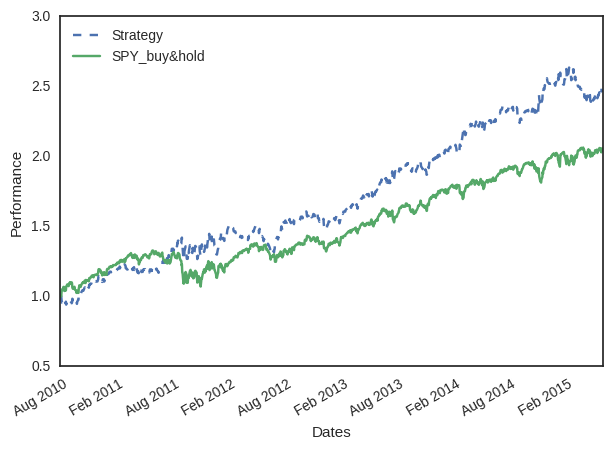

In [36]:
fitAndPlot(all_train_features,all_test_features, RandomForestRegressor, n_estimators=1000, min_samples_leaf=30,random_state=32)

This optimzed Random Forest Regression does better than the original Random Forest Regression model. The annualized return is about 2.5% higher while 
maintaining the same volatility.  

### Classification Models:
I tried Logistic, Naive Bayes, Random Forest, Decision Tree, Adaboost, and Xgboost Classification models but none of them can offer a better trading strategy than the Optimized Random Forest Model.

### Conclusion


We evaluated about 13 models, regression and classification types combined. Of all of them, only 
one stood out as the champion namely the Optimized Random Forest Regression. 

We saw that optmizing the Random Forest model improved the performance of the trading strategy. Our goal is to be able to design machine learning models 
that learn well on the training set and can generalize enough that their performance remains intact on data not included in the training. We were able to do this.
Below is a tabular ranking of the best trading strategy we got.

In [37]:
a = np.array(['Optimized Random Forest Regression'], dtype=np.str_)
b = ['18.73%']
c = ['15.14%']
d = ['1.24']
t = Table([a, b, c,d], names=('Model type ', 'Annualized Return', 'Annualized Volatility ', 'Sharpe Ratio '))
t

<Table length=1>
           Model type              Annualized Return ... Sharpe Ratio 
              str34                       str6       ...      str4    
---------------------------------- ----------------- ... -------------
Optimized Random Forest Regression            18.73% ...          1.24